# Our libraries

In [1]:
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from  sklearn.model_selection import train_test_split 
from torch.utils.data import Dataset, TensorDataset
import functools
import operator

# The helper functions for plotting and creating a pytorch dataset

In [2]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()
device = set_device()

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y
        
    def __len__(self):
        return self.tensors[0].size(0)    

GPU is enabled in this notebook.


# Loading the preprocessed data and process it further more

In [45]:
# loading the preprocessed data
melspectrogram= np.load('/content/drive/MyDrive/NMA_DL_project/feature_0.npy')
chroma_stft= np.load('/content/drive/MyDrive/NMA_DL_project/feature_3.npy')
labels= np.load('/content/drive/MyDrive/NMA_DL_project/all_the_labels.npy')

# compining both features and adding the channel dimention
compined_feat= np.concatenate( (melspectrogram , chroma_stft ), axis=1).reshape( 2970,1,140, 108)

x_train , x_test , y_train , y_test = train_test_split( compined_feat , labels , train_size=0.8, stratify=labels )
x_val , x_test , y_val , y_test= train_test_split( x_test , y_test , train_size=0.5 )

transform =transforms.GaussianBlur(3 , (0.001,0.5))

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)
x_val= torch.tensor(x_val)
y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)
y_val=  torch.tensor(y_val)

train_dataset= CustomTensorDataset(tensors=(x_train, y_train),  transform=transform)
test_dataset = CustomTensorDataset(tensors=(x_test, y_test))
val_dataset= CustomTensorDataset(tensors=(x_val, y_val))

train_loader=torch.utils.data.DataLoader(train_dataset ,batch_size=30)
test_loader=torch.utils.data.DataLoader(test_dataset ,batch_size=30)
val_loader=torch.utils.data.DataLoader(val_dataset ,batch_size=30)

# Building the model

In [4]:
class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 108)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 64, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 64 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.3),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 128 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels= 256, kernel_size=3, stride=1 , padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 256 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Dropout(0.4),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 512 ) ,
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=256),
            nn.Dropout(0.4),
            nn.Linear(in_features=256, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

# Creating the training loop

In [43]:
def train(model, device, train_loader, validation_loader, epochs , lr ):
  criterion =  nn.CrossEntropyLoss( )
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99 )
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      if epoch%5==0 & epoch>0:
         for param_group in optimizer.param_groups:
                param_group['lr'] /= 5
                print('new lr=' , param_group['lr'] )
       
      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device, dtype=torch.float ), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)
      print(f'Epoch: {epoch+1}')
      print(f'The Train accuracy= {train_acc[epoch]} \n The Validation acc {validation_acc[epoch]}') 
      print(f'The Train loss= {train_loss[epoch]} \n The Validation loss {validation_loss[epoch]}')  
      print('\n')

  return train_loss, train_acc, validation_loss, validation_acc


# Training the model

Epoch: 1
The Train accuracy= 0.21717171717171718 
 The Validation acc 0.4444444444444444
The Train loss= 2.1669585704803467 
 The Validation loss 1.6486656188964843


Epoch: 2
The Train accuracy= 0.4078282828282828 
 The Validation acc 0.4107744107744108
The Train loss= 1.6607738733291626 
 The Validation loss 1.5221269011497498


Epoch: 3
The Train accuracy= 0.45454545454545453 
 The Validation acc 0.4377104377104377
The Train loss= 1.510327696800232 
 The Validation loss 1.5341783940792084


Epoch: 4
The Train accuracy= 0.49747474747474746 
 The Validation acc 0.49158249158249157
The Train loss= 1.398131012916565 
 The Validation loss 1.4337509870529175


Epoch: 5
The Train accuracy= 0.547979797979798 
 The Validation acc 0.5185185185185185
The Train loss= 1.3120213747024536 
 The Validation loss 1.2823481380939483


Epoch: 6
The Train accuracy= 0.5829124579124579 
 The Validation acc 0.5420875420875421
The Train loss= 1.1691697835922241 
 The Validation loss 1.3909316062927246


Epo

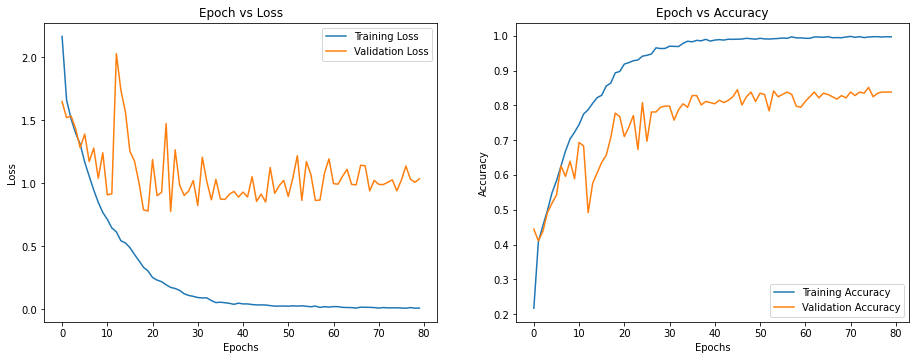

In [46]:
net = music_CNN().to(device)
init_lr = 0.0001
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 80, init_lr)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# Testing on Test set

In [94]:
criterion =  nn.CrossEntropyLoss()
running_loss=0
total=0
correct=0
test_loss=[]
test_acc=[]
for data, target in test_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        test_loss.append(running_loss/len(test_loader))
        test_acc.append(correct/total)

print(f'The test acc {np.mean(test_acc)}') 
print(f'The test loss {np.mean(test_loss)}')  

The test acc 0.8263904521404521
The test loss 0.5557383342087269


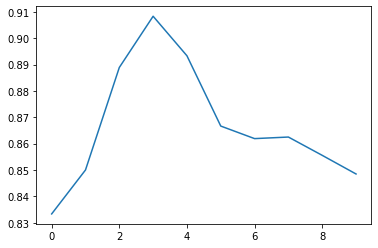

In [86]:
plt.plot(test_acc)

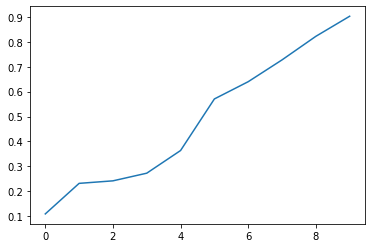

In [87]:
plt.plot(test_loss)

# Saving the model with val accuracy 81%

In [88]:
torch.save(net.state_dict(), 'final_model.cp')

In [89]:
tmp_model= music_CNN()
tmp_model.load_state_dict(torch.load( 'final_model.cp' ))

<All keys matched successfully>

In [101]:
def validate_model(model):
    criterion =  nn.CrossEntropyLoss()
    running_loss=0
    total=0
    correct=0
    validation_loss,validation_acc=[],[]
    for data, target in test_loader:
            # getting the validation set
            data, target = data.to(device, dtype=torch.float), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            #tepochs.set_postfix(loss=loss.item())
            running_loss += loss.item()
            # get accuracy
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            validation_loss.append(running_loss/len(test_loader))
            validation_acc.append(correct/total)

    print(f'The Validation acc {np.mean(validation_acc)}') 
    print(f'The Validation loss {np.mean(validation_loss)}')  
    print('\n')

validate_model(tmp_model.to('cuda') )

The Validation acc 0.8061903559403559
The Validation loss 0.5828104059398175




copying the trained model into my drive

In [1]:
!cp  '/content/final_model.cp' '/content/drive/MyDrive/NMA_DL_project'

cp: cannot stat '/content/final_model.cp': No such file or directory


# Testing

In [93]:
def classify_music( path ):
    import librosa
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning,)
    classes=[ 'classical ', 'hiphop', 'pop','country',
                     'disco', 'reggae', 'jazz', 'rock', 'blues', 'metal']
    music_loc= path # insert path for the audio wav file prefereably
    y, sr = librosa.load(music_loc)
    y_resamble= librosa.resample(y[110299:110299*2], 22050, 11025)
    C_STFT= librosa.feature.chroma_stft( y_resamble, sr=11025  )
    S = librosa.feature.melspectrogram( y_resamble, sr=11025  )
    S_DB = librosa.amplitude_to_db(S, ref=np.max)
    input_test= np.concatenate( (S_DB , C_STFT), axis=0).reshape( 1,1,140, 108)
    input_test=torch.tensor(input_test, device='cuda')
    # we are using the tmp_model that I saved it's weights b4

    idx= torch.argmax(F.softmax( tmp_model( input_test ).to('cuda') , dim=0  )) 
    return print(f' Genre is: {classes[idx]}')


In [95]:
classify_music( '/content/jazz_song.mp3' ) # this is let's face the music and dance song by nat king cole

 Genre is: classical 


# trying diff thing


In [73]:
# import csv
# from torch.autograd import Variable

# new_net = music_CNN().to(device)

# result_folder = './results/'
# if not os.path.exists(result_folder):
#     os.makedirs(result_folder)
# best_acc=0
# logname = result_folder + net.__class__.__name__ + '_pretrain' + '.csv'
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9 ) #, weight_decay=1e-4)
# # Training & Test functions
# def train(net, epoch, use_cuda=True):
#   print('\nEpoch: %d' % epoch)
#   net.train()

#   train_loss = 0
#   correct = 0
#   total = 0
#   for batch_idx, (inputs, targets) in enumerate(train_loader):
#     if use_cuda:
#       inputs, targets = inputs.to('cuda', dtype=torch.float) , targets.to('cuda')

#     optimizer.zero_grad()

#     outputs = net(inputs)
#     loss = criterion(outputs, targets)
#     loss.backward()
#     optimizer.step()

#     train_loss += loss.item()
#     _, predicted = torch.max(outputs.data, 1)
#     total += targets.size(0)
#     correct += predicted.eq(targets.data).cpu().sum()

#     if batch_idx % 500 == 0:
#       print(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#           % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
#   return (train_loss/batch_idx, 100.*correct/total)


# def test(net, epoch, outModelName, use_cuda=True):
#   global best_acc
#   net.eval()
#   test_loss, correct, total = 0, 0, 0
#   with torch.no_grad():
#     for batch_idx, (inputs, targets) in enumerate(test_loader):
#       if use_cuda:
#         inputs, targets = inputs.to('cuda', dtype=torch.float) , targets.cuda()

#       outputs = net(inputs)
#       loss = criterion(outputs, targets)

#       test_loss += loss.item()
#       _, predicted = torch.max(outputs.data, 1)
#       total += targets.size(0)
#       correct += predicted.eq(targets.data).cpu().sum()

#       if batch_idx % 200 == 0:
#         print(batch_idx, len(test_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

#   # Save checkpoint.
#   acc = 100.*correct/total
#   if acc > best_acc:
#     best_acc = acc
#     checkpoint(net, acc, epoch, outModelName)
#   return (test_loss/batch_idx, 100.*correct/total)

#   # checkpoint & adjust_learning_rate
# def checkpoint(model, acc, epoch, outModelName):
#   # Save checkpoint.
#   print('Saving..')
#   state = {
#       'state_dict': model.state_dict(),
#       'acc': acc,
#       'epoch': epoch,
#       'rng_state': torch.get_rng_state()
#   }
#   if not os.path.isdir('checkpoint'):
#       os.mkdir('checkpoint')
#   torch.save(state, f'./checkpoint/{outModelName}.t7')

# def adjust_learning_rate(optimizer, epoch):
#   if epoch >= 10:
#     for param_group in optimizer.param_groups:
#         param_group['lr'] /= 5

#     # Start training
# outModelName = 'try_me'
# if not os.path.exists(logname):
#   with open(logname, 'w') as logfile:
#       logwriter = csv.writer(logfile, delimiter=',')
#       logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])

# for epoch in range( 50):
#   adjust_learning_rate(optimizer, epoch)
#   train_loss, train_acc = train(new_net, epoch)
#   test_loss, test_acc = test(new_net, epoch, outModelName)
#   with open(logname, 'a') as logfile:
#     logwriter = csv.writer(logfile, delimiter=',')
#     logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])
#   print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')